# LIME

모델이 현재 데이터의 어떤 영역을 집중해서 분석했고

어떤 영역을 분류 근거로 사용했는지 알려주는 XAI 기법이다.

이 기법은 모델 학습 기법과 관계없이 적용할 수 있다.

<br>

LIME은 학습한 모델에 대해 하이라이트 기능을 제공한다.

입력 데이터에 대해 부분적으로 변화를 주는데, 이것을 변형(perturbation) 

또는 샘플 퍼뮤테이션(sample permutation)이라고 한다.


이미지 데이터에 LIME을 적용하는 것을 예로 든다.

어떤 이미지가 주어졌을 때 특정 관심 영역과 그와 동일한 정보를 가지고 있다고 간주할 수 있는 슈퍼 픽셀을 찾는다.

이미지를 입력받는 블랙박스 모델 f와 슈퍼 픽셀과 마스킹 정보를 입력받아 f와 동일한 값을 반환하도록 학습한 해석가능한 모델 g를 만든다.

이때 g는 사람이 이해할 수 있는 모델로 단순한 선형결합 모델을 사용할 수도 있다.

g는 슈퍼 픽셀이 블랙박스 모델이 예측하는 데 얼마만큼 영향을 미치는가를 예측한다.

여러 가지의 슈퍼 픽셀을 가지고 그 영역이 얼마만큼의 중요도를 갖는지 찾는다.

<br>

LIME은 이미지 근방을 샘플링하며 원래 이미지를 입력으로 받은 f의 출력과

슈퍼 픽셀들로 일부만 선택한 이미지를 입력으로 받은 f의 출력이 비슷한 결과를 내는지,

입력 이미지와 근처 이미지는 얼마나 유사한지를 구하여 결정 경계(decision boundary)를 구한다.

**LIME의 장점은 다음과 같다.**

1. LIME은 머신러닝 알고리즘에 관계없이 XAI를 적용할 수 있다. LIME은 입력 데이터를 변형해서 설명 가능성을 조사한다. 따라서 LIME은 모델의 종류에 구애받지 않는다. LIME은 딥러닝 기법이나 비싼 그래픽 카드를 사용하지 않아도 적용할 수 있다.

2. LIME은 매트릭스로 표현 가능한 데이터(이미지, 텍스트)에 작동하는 XAI 기법이다. LIME은 서브모듈러를 찾고 그것을 설명하기 떄문에 결과가 직관적이다.

3. LIME은 다른 XAI 기법과 비교했을 때 매우 가볍다.

반면 LIME의 불확실성도 있다. 

슈퍼 픽셀을 구하는 알고리즘과 구하는 모델 g의 결정 경계를 확정 짓는 방식이 비결정적이다.

LIME은 슈퍼 픽셀 알고리즘에 따라 마스킹 데이터가 달라진다.

또한 모델 g는 샘플링 위치에 따라 랜덤한 결과를 보일 수 있다.

마지막으로 LIME은 데이터 하나에 대해 설명을 하기 때문에 모델 전체에 대한 일관성을 보전하지 못하는 약점을 가질 수 있다.

원 논문에서는 이와 같은 한계를 인지하고 데이터셋 전체에 대해 대표성을 띄는 서브모듈러를 선정하는 알고리즘이다.

# 텍스트 데이터에 LIME 적용하기

In [1]:
# sklearn 패키지의 20 news groups 데이터셋을 가져오는 코드

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# 클래스 이름 줄이기
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:])
               for x in newsgroups_train.target_names]
print(class_names)

class_names[3] = 'pc.hardware'
class_names[4] = 'mac.hardware'

print(class_names)

['atheism', 'graphics', 'ms-windows.misc', 'hardware', 'hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']
['atheism', 'graphics', 'ms-windows.misc', 'pc.hardware', 'mac.hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']


In [2]:
# 제보 기사의 카테고리를 분류하는 모델을 만들고 F1 점수를 측정하는 코드

import sklearn
import sklearn.metrics
from sklearn.naive_bayes import MultinomialNB

# TF-IDF를 사용해서 문서를 숫자 벡터로 변환하는 전처리 과정
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# 학습하기
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)

# 테스트하기
pred = nb.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='weighted')

0.8350184193998174

학습한 모델에 LIME을 적용하고 하이라이트 표시를 한다.

In [3]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(vectorizer, nb)

predict_classes = pipe.predict_proba([newsgroups_test.data[0]]).round(3)[0]

print(predict_classes)

[0.001 0.01  0.003 0.047 0.006 0.002 0.003 0.521 0.022 0.008 0.025 0.
 0.331 0.003 0.006 0.    0.003 0.    0.001 0.009]


In [4]:
rank = sorted(range(len(predict_classes)),
             key = lambda i : predict_classes[i],
             reverse=True)

for rank_index in rank:
    print('[{:>5}] \t{:<3}\tclass ({:.1%})'.format(rank.index(rank_index)+ 1 ,
                                                  rank_index, predict_classes[rank_index]))

[    1] 	7  	class (52.1%)
[    2] 	12 	class (33.1%)
[    3] 	3  	class (4.7%)
[    4] 	10 	class (2.5%)
[    5] 	8  	class (2.2%)
[    6] 	1  	class (1.0%)
[    7] 	19 	class (0.9%)
[    8] 	9  	class (0.8%)
[    9] 	4  	class (0.6%)
[   10] 	14 	class (0.6%)
[   11] 	2  	class (0.3%)
[   12] 	6  	class (0.3%)
[   13] 	13 	class (0.3%)
[   14] 	16 	class (0.3%)
[   15] 	5  	class (0.2%)
[   16] 	0  	class (0.1%)
[   17] 	18 	class (0.1%)
[   18] 	11 	class (0.0%)
[   19] 	15 	class (0.0%)
[   20] 	17 	class (0.0%)


LIME 구현체는 기본적으로 텍스트, 이미지, 테이블, 선형 공간 분류 모듈이 있다.

또한 사용자가 직접 수정할 수 있는 이산 모듈과 설명 모듈을 제공한다

In [5]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names = class_names)

이 구현체는 파라미터로 피처를 선택하거나 BOW(Bag of Words) 알고리즘 수행 방식, 커널 크기 등을 수동으로 지정할 수 있다.

아래 메서드는 0번 데이터 중 일부 벡터를 변형해서 분류기 출력 결과가 달라지는지 추적하고

입력된 모델을 모사하는 선형 모델을 만든다. 

이 선형 모델의 카테고리 분류 기준이 결정 경계가 되고, 결정 경계에 걸리는 0번 데이터의 단어 집합이 서브모듈로 출력된다.

In [6]:
exp = explainer.explain_instance(newsgroups_test.data[0],
                                pipe.predict_proba,
                                top_labels=1)
print(exp.available_labels())

/root/anaconda3/envs/xai/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


[7]


In [7]:
exp.show_in_notebook(text=newsgroups_test.data[0])

텍스트 하이라이트로 확인할 수 있는 것은 88-89와 SE 모델이 자동차(auto) 카테고리를 결정하는 서브모듈러라는 점이다.

In [8]:
# 테스트 데이터 5번을 LIME 알고리즘에 입력하는 코드

from lime.lime_text import LimeTextExplainer

idx = 5

explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(newsgroups_test.data[idx],
                                pipe.predict_proba,
                                top_labels=1)

predict_classes = pipe.predict_proba([newsgroups_test.data[idx]]).round(3)[0]
rank = sorted(range(len(predict_classes)),
             key=lambda i: predict_classes[i], reverse=True)

print('Document id: %d' % idx)
print('Predicted class: %s' % class_names[nb.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s'% class_names[newsgroups_test.target[idx]])
print(predict_classes)
print(rank)

print('Explanation for class %s'% class_names[rank[0]])
print('\n'.join(map(str, exp.as_list(rank[0]))))

exp.show_in_notebook(text=newsgroups_test.data[idx])

/root/anaconda3/envs/xai/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Document id: 5
Predicted class: med
True class: med
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
Explanation for class med
('Candida', 0.0016285681258442443)
('fungus', 0.0016212482905082165)
('Yeast', 0.0015499145709641168)
('infections', 0.0015279856009460643)
('yeast', 0.0014751434061012975)
('systemic', 0.0014712340572655205)
('biochemist', 0.0014673547588376639)
('patients', 0.0013962804036186003)
('Connection', 0.0013861938441563299)
('ocom', 0.0012775619465797631)


텍스트 환경에서 LIME이 잘 동작하는지 확인했다.

LIME은 서브모듈 하이라이트 기능을 제공하고, 

LIME이 하이라이트 표시한 부분을 근거로 모델의 판단 근거를 확인할 수 있었다.

**LIME의 텍스트 설명체(Text Explainer)는 인공지능이 잘 된 결정을 내렸을 때 근거를 파악하게 해줄 뿐만 아니라 모델을 수정해야 할 방향을 제시한다.**
<br><br><br>

# 이미지 데이터에 LIME 적용하기


/root/anaconda3/envs/xai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,


(-0.5, 1279.5, 1279.5, -0.5)

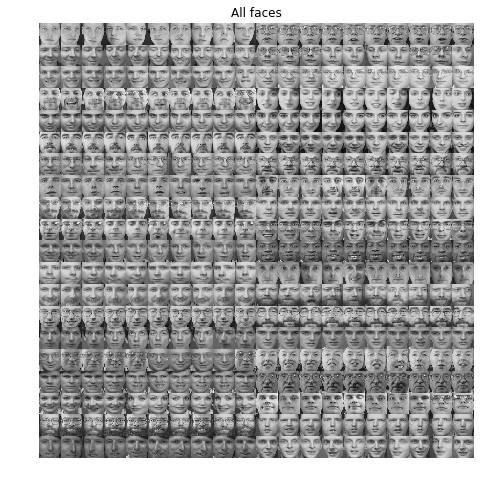

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage2d

from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

# 이미지 흑백으로 만들고 LIME이 처리할 수 있는 형태로 변환하기

X_vec = np.stack([gray2rgb(iimg)
                 for iimg in faces.data.reshape((-1,64,64))],0)

y_vec = faces.target.astype(np.uint8)

%matplotlib inline

fig, ax1 = plt.subplots(1,1, figsize=(8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]),
          cmap='gray', interpolation='none')
ax1.set_title('All faces')
ax1.axis('off')


(-0.5, 63.5, 63.5, -0.5)

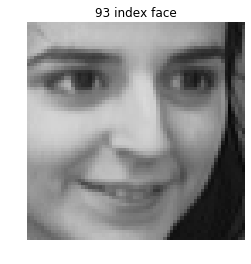

In [10]:
index = 93
plt.imshow(X_vec[index], cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

LIME의 설명체(Explainer)의 파라미터로는 (1) 설명이 필요한 데이터 하나와

(2) 해당 데이터에 대한 분류 확률을 출력하는 모델이 필요하다.

(2)의 경우 분류기 모델에서 제공하는 predict_proba 메서드가 필요하다.

텐서플로우로 만든 모델은 아래의 방식으로 사용한다.

```python
def predict_proba(image)
    return session.run(model_predict,
                       feed_dict={preprocessed_image: image})
```

프로토타이핑에는 단층 퍼센트론 네트워크를 사용해서 개념 증명(Proof of Concept, PoC)을 하고,

고도화가 필요한 경우 더 좋은 머신으로 신경망을 구축하는 편이 시행착오가 적다는 면에서 유리하다.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec,
                                                   y_vec,
                                                   train_size=0.70)

/root/anaconda3/envs/xai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
# MLP가 학습할 수 있게 이미지 전처리를 수행하는 파이프라인 생성

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
    
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = PipeStep(lambda img_list:
                        [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list:
                       [img.ravel() for img in img_list])

simple_pipeline = Pipeline([('Make Gray', makegray_step),
                           ('Flatten Image', flatten_step),
                           ('MLP', MLPClassifier(activation = 'relu',
                                                hidden_layer_sizes=(400,40),
                                                random_state =1))])

simple_pipeline.fit(X_train, y_train)

/root/anaconda3/envs/xai/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('Make Gray', <__main__.PipeStep object at 0x7f45795bf080>), ('Flatten Image', <__main__.PipeStep object at 0x7f45795bf198>), ('MLP', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_siz...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [13]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         5
           4       0.75      0.60      0.67         5
           5       1.00      0.25      0.40         4
           6       1.00      1.00      1.00         4
           7       0.67      0.40      0.50         5
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         2
          11       1.00      0.50      0.67         4
          12       0.25      0.33      0.29         3
          13       0.67      1.00      0.80         2
          14       0.57      1.00      0.73         4
          15       0.25      1.00      0.40         1
          16       0.60      0.75      0.67         4
          17       1.00      1.00      1.00         1
          18       0.75    

/root/anaconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
# Normalizer 전처리 과정을 추가하여 MLP를 학습시키는 코드

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
    
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = PipeStep(lambda img_list:
                        [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list:
                       [img.ravel() for img in img_list])

simple_pipeline = Pipeline([('Make Gray', makegray_step),
                           ('Flatten Image', flatten_step),
                            ('Normalizer', Normalizer()),
                           ('MLP', MLPClassifier(activation = 'relu',
                                                 alpha=1e-7,
                                                 epsilon=1e-6,
                                                hidden_layer_sizes=(800,120),
                                                random_state =1))])

simple_pipeline.fit(X_train, y_train)

/root/anaconda3/envs/xai/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('Make Gray', <__main__.PipeStep object at 0x7f45796401d0>), ('Flatten Image', <__main__.PipeStep object at 0x7f4579640b00>), ('Normalizer', Normalizer(copy=True, norm='l2')), ('MLP', MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopp...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [15]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       1.00      1.00      1.00         3
           2       0.67      1.00      0.80         2
           3       1.00      0.60      0.75         5
           4       0.60      0.60      0.60         5
           5       1.00      1.00      1.00         4
           6       0.60      0.75      0.67         4
           7       0.67      0.80      0.73         5
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         4
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         2
          14       0.80      1.00      0.89         4
          15       1.00      1.00      1.00         1
          16       0.60      0.75      0.67         4
          17       1.00      1.00      1.00         1
          18       1.00    

20번 인물의 정확도는 약 50%이다. 

그러나 점수로만 결과를 확인할 수 있을 뿐, 어떻게 해석하는지는 알 수 없다.

LIME을 사용해서 MLP가 잘 분류하는 인물들과 헷갈리는 인물들을 어떻게 인식하고 있는지 알아본다.

LIME의 이미지 설명체를 선언하고 이미지 분할 알고리즘(segmentation algorithm)을 지정한다.

In [16]:
# LIME의 이미지 설명체와 이미지 분할 알고리즘을 선언하는 코드

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘: quickshift(기본), slic, felzenswalb

segmenter = SegmentationAlgorithm('slic',
                                 n_segments = 100,
                                 compactness = 1,
                                 sigma = 1)

In [17]:
%%time

# 테스트 0번 이미지에 대해 설명 모델을 구축하는 코드

olivetti_test_index = 0

exp = explainer.explain_instance(X_test[olivetti_test_index],
                                classifier_fn=simple_pipeline.predict_proba,
                                top_labels=6,
                                num_samples=1000,
                                segmentation_fn=segmenter)


CPU times: user 4.35 s, sys: 7.48 s, total: 11.8 s
Wall time: 748 ms


Text(0.5, 1.0, 'Show mask only')

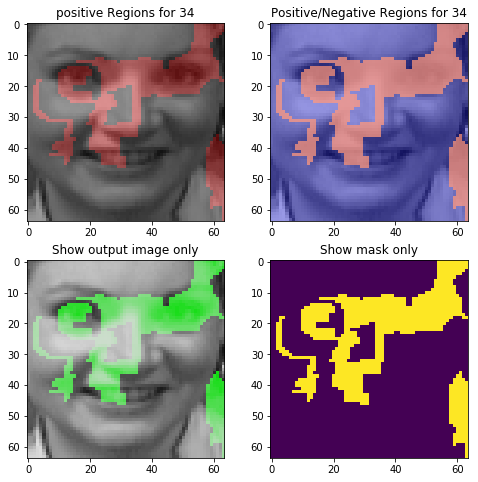

In [19]:
# 올리베티 데이터 0번을 설명체에 통과시켜 XAI를 수행하는 코드

from skimage.color import label2rgb

# 캔버스 설정하기
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8))

# 예측에 도움이 되는 세그먼트 출력하기
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                   positive_only=True,
                                   num_features=8,
                                   hide_rest=False)

ax1.imshow(label2rgb(mask, temp, bg_label = 0),
          interpolation = 'nearest')
ax1.set_title('positive Regions for {}'.format(y_test[olivetti_test_index]))

# 모든 세그먼트 출력하기
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                   positive_only=False,
                                   num_features=8,
                                   hide_rest=False)

ax2.imshow(label2rgb(4 - mask, temp, bg_label = 0),
          interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation = 'nearest')
ax4.set_title('Show mask only')

ax1은 설명 모델이 가장 높은 확률로 분류한 라벨에 도움이 되는 이미지 영역만을 표시한다.

ax2는 모든 이미지 조각 마스킹 레이블을 출력한다.

ax3는 설명 모델이 유용하게 사용한 이미지 조각만을 출력한다.

ax4는 분할 영역을 정수형 타입으로 시각화한다.

마스킹한 부분을 보면 눈, 코, 입 주변으로 몰려 있다.

일반적으로 사람의 외모를 인식할 때 흔히 들을 수 있는 답변과 유사하다.

이 결과를 통해 설명 모델은 사람과 유사한 방식으로 이미지를 인식하고 있다고 해석할 수 있다.

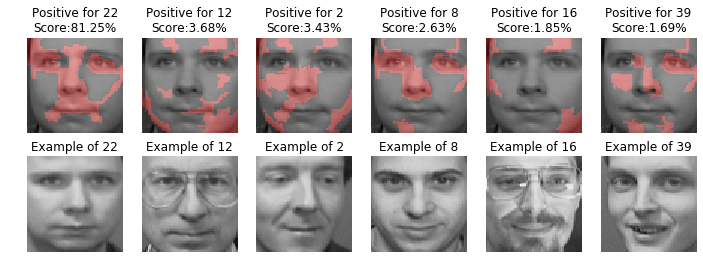

In [32]:
# 올리베티 얼굴 테스트 데이터 0번(3번 인물)으로부터 추가 설명을 출력하는 코드

olivetti_test_index = 7


exp = explainer.explain_instance(X_test[olivetti_test_index],
                                classifier_fn=simple_pipeline.predict_proba,
                                top_labels=6,
                                num_samples=1000,
                                segmentation_fn=segmenter)

fig, m_axs = plt.subplots(2, 6, figsize = (12, 4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask = exp.get_image_and_mask(i,
                                       positive_only=True,
                                       num_features=12,
                                       hide_rest=False,
                                       min_weight = 0.001)
    c_ax.imshow(label2rgb(mask, temp, bg_label = 0),
              interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[olivetti_test_index, i]))

    c_ax.axis('off')
    
    face_id = np.random.choice(np.where(y_train==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')


위의 해석으로는 설명 모델은 34번째 인물의 둥근 눈매와 코를 중점으로 파악한 것으로 확인된다.

이번에는 F1-점수가 낮은 성능을 보인 20번째 인물을 분석해본다.

LIME으로 분류 모델이 이 인물들을 어떻게 인식하는지 파악할 수 있다면 앞으로 어떤 데이터를 보강해야 

모델을 학습하는 데 도움이 될지 대안을 제시할 수 있을 것이다.

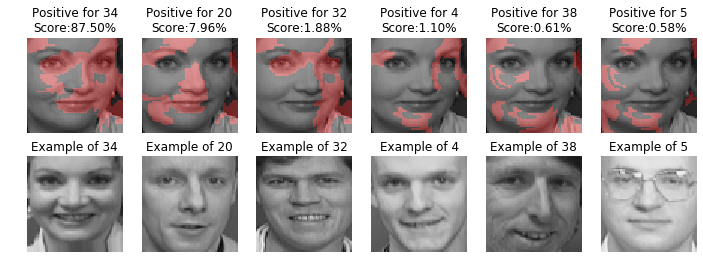

In [45]:
olivetti_test_index = 20


exp = explainer.explain_instance(X_test[olivetti_test_index],
                                classifier_fn=simple_pipeline.predict_proba,
                                top_labels=6,
                                num_samples=1000,
                                segmentation_fn=segmenter)

fig, m_axs = plt.subplots(2, 6, figsize = (12, 4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask = exp.get_image_and_mask(i,
                                       positive_only=True,
                                       num_features=12,
                                       hide_rest=False,
                                       min_weight = 0.001)
    c_ax.imshow(label2rgb(mask, temp, bg_label = 0),
              interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[olivetti_test_index, i]))

    c_ax.axis('off')
    
    face_id = np.random.choice(np.where(y_train==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')